In [1]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 458.3 MB 11 kB/s               
     |████████████████████████████████| 462 kB 53.9 MB/s            
     |████████████████████████████████| 65 kB 7.4 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 5.6 MB 45.5 MB/s            
     |████████████████████████████████| 132 kB 23.5 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 42 kB 70 kB/s              
     |████████████████████████████████| 1.3 MB 49.2 MB/s            
     |████████████████████████████████| 4.5 MB 94.1 MB/s            
     |████████████████████████████████| 97 kB 4.2 MB/s              
     |████████████████████████████████| 152 kB 115.8 MB/s            
     |████████████████████████████████| 781 kB 87.5 MB/s            
     |████████████████████████████████| 4.9 MB 50.9 MB/s            
     |████████████████████████████████| 155 kB 105.5 MB/s            
     |████████████

In [2]:
!pip install PyAthena

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
import re
!pip install swifter
!pip install textdistance
pd.options.mode.chained_assignment = None # default='warn'
# install if required
import sys
import swifter
!pip install missingno
import matplotlib.pyplot as plt

     |████████████████████████████████| 821 kB 34.3 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.3.3-py3-none-any.whl size=16238 sha256=c6bd502a7b6531155cd7c8d40a35e2c7f66ff9054b823929a8ccd0d15b78822c
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c5/d5/9d/3eb1cf6cf1a6613e6178c5293388be4c4e98865f18f782048f
Successfully built swifter


In [4]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

%%time
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor

cursor = connect(s3_staging_dir='s3://rd11shiva/',region_name='us-east-1',cursor_class=PandasCursor).cursor()

query='''SELECT year(date_parse(date_of_event, '%Y%m%d')) as event_year, product_problems, p.patient_problems  FROM "fda-open-database"."event" cross join unnest (patient) as t(p)'''
event = cursor.execute(query.format()).as_pandas()

In [5]:
%%time
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor

cursor = connect(s3_staging_dir='s3://rd11shiva/',region_name='us-east-1',cursor_class=PandasCursor).cursor()

query='''SELECT * FROM "staging"."fda_to_imdrf_lookup"'''
fda_to_imdrf_lookup = cursor.execute(query.format()).as_pandas()

CPU times: user 98.2 ms, sys: 15.2 ms, total: 113 ms
Wall time: 2.17 s


In [6]:
%%time
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor

cursor = connect(s3_staging_dir='s3://rd11shiva/',region_name='us-east-1',cursor_class=PandasCursor).cursor()

query='''with imdrf_event as
(
SELECT 
s.*,d.report_number,d.mdr_report_key,d.mdr_text FROM "AwsDataCatalog"."fda-open-database"."event" d
INNER JOIN "staging"."event_no_nlp_native_imdrf" s 
ON s.mdr_report_key=d.mdr_report_key
)

SELECT imdrf_event.device_sequence_id, imdrf_event.product_problems AS product_problem_codes, imdrf_event.patient_problems AS patient_problem_codes, imdrf_event.report_number AS rr, NM.*
FROM
(
SELECT *
FROM "AwsDataCatalog"."lbathija_db"."normalized_event_pma_after_2018" WHERE 
product_code IN ('OYC',
'LWS',
'FRN',
'MVK',
'CBK',
'DSQ',
'NVZ',
'NPT',
'FKX',
'LKK',
'MIH',
'FMI',
'MNT',
'KDI',
'LPB') and
date_of_event>=20200101 and 
date_of_event<20210101
)
AS NM
INNER JOIN imdrf_event ON ("NM"."report_number"="imdrf_event"."report_number") WHERE NM.true_cond = true  
order by date_of_event DESC'''
df_UDI_EVENT = cursor.execute(query.format()).as_pandas()

CPU times: user 1.98 s, sys: 294 ms, total: 2.28 s
Wall time: 1min 27s


In [7]:
import random
foo=list(df_UDI_EVENT.manufacturer_contact_zip_code.dropna())
df_UDI_EVENT['hospital_zip_sim']=df_UDI_EVENT['manufacturer_contact_zip_code'].apply(lambda x: random.choice(foo))

In [8]:
df_UDI_EVENT['mdr_report_key']=df_UDI_EVENT['mdr_report_key'].apply(lambda x: str(x))

and (lower(device_name) like ('pulm%')) and
date_of_event>=(select max(date_of_event) from  "lbathija_db"."normalized_event_pma_after_2018")-600 and 
date_of_event<(select max(date_of_event) from  "lbathija_db"."normalized_event_pma_after_2018")

In [9]:
len(df_UDI_EVENT)

128224

In [10]:
df_UDI_EVENT.product_code.value_counts()

OYC    48180
LWS    13849
DSQ    11581
MVK    11543
CBK     8945
NVZ     7522
FRN     6772
NPT     5017
FKX     4058
LKK     3836
MIH     2741
FMI     2049
KDI     1044
LPB     1024
MNT       63
Name: product_code, dtype: int64

In [11]:
import re
def extract_text(doc:str) -> str:
    if doc=='[]':
        return None
    regex_desc = r"text_type_code=Description of Event or Problem, patient_sequence_number=[0-9], text=([^}]+})"
    desc = list(set(re.findall(regex_desc, doc)))
    desc = ' '.join(desc).replace("}", "").lower()

    regex_addi = r"text_type_code=Additional Manufacturer Narrative, patient_sequence_number=[0-9], text=([^}]+})"
    addi = list(set(re.findall(regex_addi, doc)))
    addi = ' '.join(addi).replace("}", "").lower()

    if desc and addi:
        return desc + " " + addi
    else:
        return desc if desc else addi

In [12]:
import re
def extract_patient(doc:str) -> str:
    if doc=='[]':
        return None
    regex_desc = r"patient_problems=([^}]+})"
    desc = list(set(re.findall(regex_desc, doc)))
    desc = ' '.join(desc).replace("}", "").lower()
    return desc if desc else addi

In [13]:
df_UDI_EVENT.columns

Index(['device_sequence_id', 'product_problem_codes', 'patient_problem_codes',
       'rr', 'report_number', 'date_of_event', 'pma_pmn_number', 'brand_name',
       'manufacturer_d_name', 'manufacturer_contact_zip_code',
       'manufacturer_d_country', 'catalog_number', 'model_number',
       'lot_number', 'other_id_number', 'product_code', 'device_name',
       'device_class', 'fei_number', 'mdr_report_key', 'mdr_text', 'patient',
       'product_problems', 'normalized_pma_pmn_number', 'true_cond',
       'event_type', 'hospital_zip_sim'],
      dtype='object')

In [14]:
df_UDI_EVENT.mdr_text=df_UDI_EVENT.mdr_text.apply(lambda x: extract_text(x))
df_UDI_EVENT.patient=df_UDI_EVENT.patient.apply(lambda x: extract_patient(x))

In [15]:
df_UDI_EVENT['FEI_Number']=df_UDI_EVENT.report_number.str.split('-').str[0]
df_UDI_EVENT['date_of_event']=pd.to_datetime(df_UDI_EVENT['date_of_event'].astype(str),format='%Y-%m-%d',errors='coerce')
df_UDI_EVENT['brand_name']=df_UDI_EVENT['brand_name'].str.upper()
df_UDI_EVENT.pma_pmn_number=df_UDI_EVENT.pma_pmn_number.str.split('/|-').str[0]
df_UDI_EVENT.pma_pmn_number=df_UDI_EVENT.pma_pmn_number.str.split('.').str[0]

In [16]:
#demo_S1_S2=df_UDI_EVENT[df_UDI_EVENT.jw_score_submission_number==0]
demo_S1_S2=df_UDI_EVENT

In [17]:
demo_S1_S2['patient_product']=(demo_S1_S2['patient_problem_codes'].fillna("")+demo_S1_S2['product_problem_codes'].fillna("")).apply(lambda x: x.replace('][',', '))
demo_S1_S2['product_problems']=(demo_S1_S2['patient_problem_codes'].fillna("")+demo_S1_S2['product_problem_codes'].fillna("")).apply(lambda x: x.replace('][',', '))

In [18]:
demo_S1_S2.mdr_text=df_UDI_EVENT.date_of_event.apply(lambda x: x.strftime('%m/%d/%Y'))+'|'+demo_S1_S2.normalized_pma_pmn_number+'|'+demo_S1_S2.manufacturer_d_name+'|'+demo_S1_S2.product_code+'|'+demo_S1_S2.brand_name+'|'+demo_S1_S2.report_number+'|'+demo_S1_S2.manufacturer_contact_zip_code+'|'+demo_S1_S2.hospital_zip_sim+'|'+demo_S1_S2.FEI_Number+'|'+demo_S1_S2.device_class+'|'+demo_S1_S2.mdr_report_key+'|'+demo_S1_S2.mdr_text

In [19]:
df_UDI_EVENT[['mdr_text','mdr_report_key']].head()

,mdr_text,mdr_report_key
0,"12/31/2020|P980016|MEDTRONIC PUERTO RICO OPERATIONS CO.|LWS|EVERA MRI XT DR SURESCAN|3004209178-2021-00700|55112|84070|3004209178|3|11165302|it was reported that the implantable cardioverter defibrillator (icd) system was removed due to infection. no further patient complications have been reported as a result of this event. if information is provided in the future, a supplemental report will be issued.",11165302
1,"12/31/2020|P150001|MEDTRONIC PUERTO RICO OPERATIONS CO.|OYC|640G INSULIN PUMP MMT-1712K|2032227-2021-101840|00777|55112|2032227|3|11130694|information received by medtronic indicated that the insulin pump had a missing retainer ring. the customer stated the connection with the reservoir compartment was broken. no harm requiring medical intervention was reported. troubleshooting was not completed and no further information was provided. the insulin pump will be returned for analysis. tested with a test p-cap and the test p-cap did not lock in place properly due to missing retainer. unable to perform displacement test due to missing retainer. device received with partially broken off reservoir tube lip, missing reservoir tube o-ring, cracked select button on keypad overlay, pillowing keypad overlay, scratched or peeling keypad overlay texture, scratched display window cover, faded or stained or peeling serial number label, peeling or fading end cap address label, cracked case at belt clip rail corner and scratched case. (b)(4). currently it is unknown whether or not the device may have caused or contributed to the event as no product has been returned. the device will be returned for analysis and further information will follow once the analysis has been completed. no conclusion can be drawn at this time. the insulin pump involved in this event is the 640g insulin infusion pump, which is not marketed in the united states. however, the device is similar to the paradigm real-time insulin infusion pump, which is marketed in the united states.",11130694
2,"12/31/2020|P150001|MEDTRONIC PUERTO RICO OPERATIONS CO.|OYC|640G INSULIN PUMP MMT-1712K|2032227-2021-101385|00777|00777|2032227|3|11128970|information received by medtronic indicated that the insulin pump had a damage missing retainer ring. customer stated that the reservoir did not lock into place. customer stated that insulin pump was not drop or bumped. no harm requiring medical intervention was reported. the insulin pump will be returned for analysis. the insulin pump involved in this event is the 640g insulin infusion pump, which is not marketed in the united states. however, the device is similar to the paradigm real-time insulin infusion pump, which is marketed in the united states. (b)(4). currently it is unknown whether or not the device may have caused or contributed to the event as no product has been returned. the device will be returned for analysis and further information will follow once the analysis has been completed. no conclusion can be drawn at this time.",11128970
3,12/31/2020|P140015|TANDEM DIABETES CARE|OYC|T:SLIM G5 SYSTEM|3013756811-2021-14081|92121|55112|3013756811|3|11259969|it was reported that the customer experienced difficulties charging the pump. there was no reported impact to the customer's blood glucose level. customer declined to provide further information regarding the issue. device not returned.,11259969
4,"12/31/2020|P920015|MPRI|LWS|SPRINT QUATTRO SECURE S MRI SURESCAN|2649622-2021-00820|55112|60073|2649622|3|11163802|it was reported that the patient experienced an infection. the cardiac resynchronization therapy defibrillator (crt-d) system will be explanted. no further patient complications have been reported as a result of this event. concomitant medical products: 5071-53 lead implanted: (b)(6) 2006; 407652 lead implanted: (b)(6) 2006. if information is provided in the future, a supplemental report will be issued.",11163802


In [20]:
#df_pat_prob=df_pat_prob[~df_pat_prob.patient_problems.isna()]
#df_product_prob=df_product_prob[~df_product_prob.product_problems.isna()]
#demo_S1_S2['patient_problems'].fillna('MDR_NAN_pat_prob', inplace=True)
#demo_S1_S2['product_problems'].fillna('MDR_NAN_prod_prob', inplace=True)
demo_S1_S2['patient_product'].fillna('', inplace=True)
demo_S1_S2['mdr_text'].fillna('', inplace=True)
demo_S1_S2['event_type'].fillna('', inplace=True)

In [21]:
demo_S1_S2['patient_product_codes']=demo_S1_S2['patient_product'].apply(lambda x: x.strip("[ ]").split(", ")).astype(str)
demo_S1_S2['event_type']=demo_S1_S2['event_type'].apply(lambda x: x.strip("[ ]").split(", ")).astype(str)

In [22]:
demo_S1_S2["patient_product_codes"] = demo_S1_S2["patient_product_codes"].apply(
    lambda x: literal_eval(x)
)
demo_S1_S2["patient_product_codes"].values[:5]

array([list(['E1906', 'A24']),
       list(['F24', 'E2401', 'A26', 'A12', 'A01']),
       list(['A26', 'F24', 'E2401', 'A12', 'A01']),
       list(['E2403', 'A0706']), list(['E1906', 'A24'])], dtype=object)

In [23]:
demo_S1_S2["event_type"] = demo_S1_S2["event_type"].apply(
    lambda x: literal_eval(x)
)
demo_S1_S2["event_type"].values[:5]

array([list(['Injury']), list(['Malfunction']), list(['Malfunction']),
       list(['Malfunction']), list(['Injury'])], dtype=object)

# Patient_Product_Problems

In [24]:
test_split = 0.3

# Initial train and test split.
train_df, test_df = train_test_split(
    demo_S1_S2,
    test_size=test_split,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")
print(f"Number of rows in df_product_prob: {len(demo_S1_S2)}")

Number of rows in training set: 89756
Number of rows in validation set: 19234
Number of rows in test set: 19234
Number of rows in df_product_prob: 128224


In [26]:
product_problems = tf.ragged.constant(train_df["patient_product_codes"].values)

lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(product_problems)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'A01', 'A24', 'E2403', 'F24', 'E2401', 'A26', 'F27', 'A0705', 'A0708', 'A05', 'A070909', 'A12', 'E1906', 'A141204', 'E210401', 'A071302', 'E1205', 'A050401', 'A0401', 'A1601', 'F02', 'A090801', 'A0721', 'A1409', 'A070504', 'A072201', 'E2104', 'A16', 'A070803', 'A0706', 'A090201', 'A090206', 'A1407', 'A090805', 'A14', 'A2202', 'A1603', 'A07', 'A0504', 'A0902', 'A040101', 'A0709', 'E0306', 'A070908', 'E1206', 'A1905', 'A13', 'A0509', 'F28', 'A27', 'A04', 'A160105', 'A070603', 'A09', 'E2330', 'A0712', 'E1024', 'A051201', 'E0601', 'A090406', 'E20', 'E0133', 'A1402', 'A070102', 'A0722', 'A23', 'A1412', 'A140801', 'A0802', 'A1301', 'A0203', 'A1305', 'A25', 'E0506', 'E1713', 'A1006', 'A0404', 'A070910', 'A0104', 'A160503', 'A0414', 'E0501', 'A1107', 'A1403', 'E0605', 'E1002', 'A0101', 'E1901', 'E0514', 'E2321', 'A0202', 'E1720', 'A050405', 'E2107', 'A071102', 'A040609', 'E0602', 'A070101', 'A11', 'E120501', 'E060104', 'E0717', 'A072001', 'A070801', 'A072202', 'A090811',

In [27]:
sample_label = train_df["patient_product_codes"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['A1601']
Label-binarized representation: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [28]:
train_df["mdr_text"].apply(lambda x: len(x.split(" "))).describe()

count    89756.000000
mean       124.597397
std        104.597496
min          1.000000
25%         59.000000
50%        104.000000
75%        162.000000
max       2546.000000
Name: mdr_text, dtype: float64

In [29]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["patient_product_codes"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["mdr_text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [30]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [31]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"MDR Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

MDR Text: b"01/06/2020|P150001|MEDTRONIC PUERTO RICO OPERATIONS CO.|OYC|640G INSULIN PUMP MMT-1712K|3004209178-2020-54051|00777|94588|3004209178|3|9574240|it was reported that the retainer ring was missing and the reservoir was not able to lock in place when inserted into the insulin pump. the customer's blood glucose level was unknown at the time of the incident. the customer was advised to discontinue use of the insulin pump and to revert to the back-up plan. the device will be returned for analysis. (b)(4). currently it is unknown whether or not the device may have caused or contributed to the event as no product has been returned. the device will be returned for analysis and further information will follow once the analysis has been completed. no conclusion can be drawn at this time. the insulin pump involved in this event is the 640g insulin infusion pump, which is not marketed in the united states. however, the device is similar to the paradigm real-time insulin infusion pump, wh

In [32]:
vocabulary = set()
train_df["mdr_text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

166057


In [33]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [34]:
from tensorflow.keras.layers import Dropout

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(256, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  
    )
    return shallow_mlp_model

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

Epoch 1/5
702/702 [==============================] - 304s 432ms/step - loss: 0.0197 - categorical_accuracy: 0.5271 - val_loss: 0.0057 - val_categorical_accuracy: 0.5992
Epoch 2/5
702/702 [==============================] - 302s 430ms/step - loss: 0.0052 - categorical_accuracy: 0.6119 - val_loss: 0.0054 - val_categorical_accuracy: 0.5852
Epoch 3/5
702/702 [==============================] - 303s 431ms/step - loss: 0.0043 - categorical_accuracy: 0.6250 - val_loss: 0.0055 - val_categorical_accuracy: 0.5781
Epoch 4/5
702/702 [==============================] - 303s 431ms/step - loss: 0.0039 - categorical_accuracy: 0.6283 - val_loss: 0.0056 - val_categorical_accuracy: 0.5905
Epoch 5/5
702/702 [==============================] - 302s 431ms/step - loss: 0.0036 - categorical_accuracy: 0.6317 - val_loss: 0.0059 - val_categorical_accuracy: 0.5705


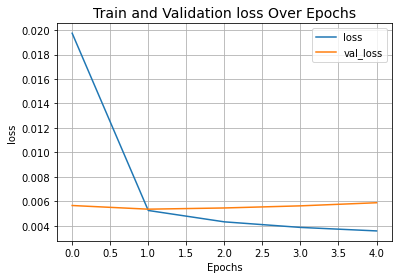

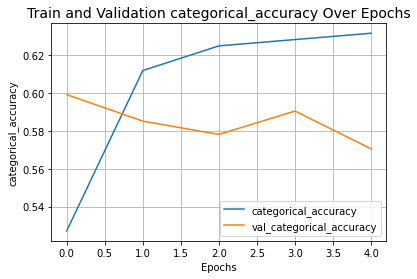

In [36]:
epochs = 5

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stop]
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [37]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

151/151 [==============================] - 21s 135ms/step - loss: 0.0060 - categorical_accuracy: 0.5699
Categorical accuracy on the test set: 56.99%.


In [38]:
_, categorical_acc = shallow_mlp_model.evaluate(train_dataset)
print(f"Categorical accuracy on the train set: {round(categorical_acc * 100, 2)}%.")

702/702 [==============================] - 97s 137ms/step - loss: 0.0026 - categorical_accuracy: 0.6193
Categorical accuracy on the train set: 61.93%.


In [39]:
_, categorical_acc = shallow_mlp_model.evaluate(validation_dataset)
print(f"Categorical accuracy on the validation set: {round(categorical_acc * 100, 2)}%.")

151/151 [==============================] - 21s 135ms/step - loss: 0.0059 - categorical_accuracy: 0.5705
Categorical accuracy on the validation set: 57.05%.


In [40]:
lis=[]
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
batch_size=len(test_df)
inference_dataset = make_dataset(test_df, is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch):
    label = label_batch[i].numpy()[None, ...]
    #print(f"MDR Text: {text}")
    #print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_5_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    top_5_score = [
        x
        for x, _ in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    #print(f"Predicted Label(s): ({', '.join([label for label in top_5_labels])})")
    #print(" ")
    lis.append([text.numpy(),invert_multi_hot(label[0]),[label for label in top_5_labels],[score for score in top_5_score]])
    
cols=['MDR Text','MDR Problem Codes', 'NLP Problem Codes','NLP score']
Results_Summary_test= pd.DataFrame(lis, columns=cols)

In [41]:
lis=[]
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
batch_size=len(train_df)
inference_dataset = make_dataset(train_df, is_train=True)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch):
    label = label_batch[i].numpy()[None, ...]
    #print(f"MDR Text: {text}")
    #print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_5_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    top_5_score = [
        x
        for x, _ in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    #print(f"Predicted Label(s): ({', '.join([label for label in top_5_labels])})")
    #print(" ")
    lis.append([text.numpy(),invert_multi_hot(label[0]),[label for label in top_5_labels],[score for score in top_5_score]])
    
cols=['MDR Text','MDR Problem Codes', 'NLP Problem Codes','NLP score']
Results_Summary_train= pd.DataFrame(lis, columns=cols)

In [42]:
lis=[]
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
batch_size=len(val_df)
inference_dataset = make_dataset(val_df, is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch):
    label = label_batch[i].numpy()[None, ...]
    #print(f"MDR Text: {text}")
    #print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_5_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    top_5_score = [
        x
        for x, _ in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    #print(f"Predicted Label(s): ({', '.join([label for label in top_5_labels])})")
    #print(" ")
    lis.append([text.numpy(),invert_multi_hot(label[0]),[label for label in top_5_labels],[score for score in top_5_score]])
    
cols=['MDR Text','MDR Problem Codes', 'NLP Problem Codes','NLP score']
Results_Summary_val= pd.DataFrame(lis, columns=cols)

# Event_Type

In [43]:
eve_type = tf.ragged.constant(train_df["event_type"].values)

lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(eve_type)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'Malfunction', 'Injury', 'Death', 'No answer provided']


In [44]:
sample_label = train_df["event_type"].iloc[5]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Malfunction']
Label-binarized representation: [[0. 1. 0. 0. 0.]]


In [45]:
train_df["mdr_text"].apply(lambda x: len(x.split(" "))).describe()

count    89756.000000
mean       124.597397
std        104.597496
min          1.000000
25%         59.000000
50%        104.000000
75%        162.000000
max       2546.000000
Name: mdr_text, dtype: float64

In [46]:
max_seqlen = 420
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["event_type"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["mdr_text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [47]:
train_dataset = make_dataset(train_df[['mdr_text','event_type']], is_train=True)
validation_dataset = make_dataset(val_df[['mdr_text','event_type']], is_train=False)
test_dataset = make_dataset(test_df[['mdr_text','event_type']], is_train=False)

In [48]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"MDR Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

MDR Text: b'05/28/2020|P110042/S058|BOSTON SCIENTIFIC CORPORATION|LWS|EMBLEM MRI S-ICD|2124215-2020-13246|55112|00777|2124215|3|10253665|it was reported that there was observed oversensing resulting in an inappropriate shock as well as rhythm acceleration when it comes to this device. the episode was seen via remote monitoring. no adverse patient effects were reported. this device remains implanted.'
Label(s): ['Malfunction']
 
MDR Text: b"06/13/2020|P920015|MPRI|LWS|SPRINT QUATTRO SECURE S MRI SURESCAN|2649622-2020-18880|55112|55112|2649622|3|10612631|it was reported that the patient was in the emergency room (er). the patient indicated that three shocks were received earlier that day. it was discovered that an electrical reset occurred, and the shocks could not be confirmed due to missing diagnostics. it was further reported that insulation damage on the right ventricular (rv) lead caused the electrical reset on the icd. the icd and rv lead were explanted and replaced. no further pat

In [49]:
vocabulary = set()
train_df["mdr_text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

166057


In [50]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [51]:
from tensorflow.keras.layers import Dropout

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(256, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  
    )
    return shallow_mlp_model

In [52]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

Epoch 1/5
702/702 [==============================] - 301s 427ms/step - loss: 0.1020 - categorical_accuracy: 0.9122 - val_loss: 0.0812 - val_categorical_accuracy: 0.9230
Epoch 2/5
702/702 [==============================] - 301s 428ms/step - loss: 0.0561 - categorical_accuracy: 0.9464 - val_loss: 0.0865 - val_categorical_accuracy: 0.9258
Epoch 3/5
702/702 [==============================] - 301s 428ms/step - loss: 0.0420 - categorical_accuracy: 0.9584 - val_loss: 0.1099 - val_categorical_accuracy: 0.9237
Epoch 4/5
702/702 [==============================] - 300s 427ms/step - loss: 0.0378 - categorical_accuracy: 0.9621 - val_loss: 0.1164 - val_categorical_accuracy: 0.9258
Epoch 5/5
702/702 [==============================] - 300s 428ms/step - loss: 0.0360 - categorical_accuracy: 0.9633 - val_loss: 0.1219 - val_categorical_accuracy: 0.9238


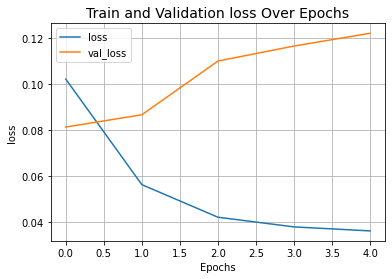

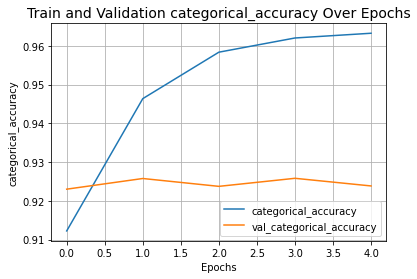

In [53]:
epochs = 5

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stop]
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [54]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

151/151 [==============================] - 20s 133ms/step - loss: 0.1265 - categorical_accuracy: 0.9224
Categorical accuracy on the test set: 92.24%.


In [55]:
_, categorical_acc = shallow_mlp_model.evaluate(train_dataset)
print(f"Categorical accuracy on the train set: {round(categorical_acc * 100, 2)}%.")

702/702 [==============================] - 96s 136ms/step - loss: 0.0342 - categorical_accuracy: 0.9650
Categorical accuracy on the train set: 96.5%.


In [56]:
_, categorical_acc = shallow_mlp_model.evaluate(validation_dataset)
print(f"Categorical accuracy on the validation set: {round(categorical_acc * 100, 2)}%.")

151/151 [==============================] - 20s 133ms/step - loss: 0.1219 - categorical_accuracy: 0.9238
Categorical accuracy on the validation set: 92.38%.


In [57]:
lis=[]
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
batch_size=len(test_df)
inference_dataset = make_dataset(test_df, is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch):
    label = label_batch[i].numpy()[None, ...]
    #print(f"MDR Text: {text}")
    #print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_5_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    top_5_score = [
        x
        for x, _ in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    #print(f"Predicted Label(s): ({', '.join([label for label in top_5_labels])})")
    #print(" ")
    lis.append([text.numpy(),invert_multi_hot(label[0]),[label for label in top_5_labels],[score for score in top_5_score]])
    
cols=['MDR Text','MDR event Type', 'NLP Event Type','NLP score ET']
Results_Summary_test_ET= pd.DataFrame(lis, columns=cols)

In [58]:
lis=[]
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
batch_size=len(train_df)
inference_dataset = make_dataset(train_df, is_train=True)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch):
    label = label_batch[i].numpy()[None, ...]
    #print(f"MDR Text: {text}")
    #print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_5_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    top_5_score = [
        x
        for x, _ in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    #print(f"Predicted Label(s): ({', '.join([label for label in top_5_labels])})")
    #print(" ")
    lis.append([text.numpy(),invert_multi_hot(label[0]),[label for label in top_5_labels],[score for score in top_5_score]])
    
cols=['MDR Text','MDR event Type', 'NLP Event Type','NLP score ET']
Results_Summary_train_ET= pd.DataFrame(lis, columns=cols)

In [59]:
lis=[]
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
batch_size=len(val_df)
inference_dataset = make_dataset(val_df, is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch):
    label = label_batch[i].numpy()[None, ...]
    #print(f"MDR Text: {text}")
    #print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_5_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    top_5_score = [
        x
        for x, _ in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    #print(f"Predicted Label(s): ({', '.join([label for label in top_5_labels])})")
    #print(" ")
    lis.append([text.numpy(),invert_multi_hot(label[0]),[label for label in top_5_labels],[score for score in top_5_score]])
    
cols=['MDR Text','MDR event Type', 'NLP Event Type','NLP score ET']
Results_Summary_val_ET= pd.DataFrame(lis, columns=cols)

# Compile Results

In [60]:
Results_Summary_PC=pd.concat([Results_Summary_train, Results_Summary_val, Results_Summary_test])
Results_Summary_PC=Results_Summary_PC.reset_index()

In [61]:
Results_Summary_ET=pd.concat([Results_Summary_train_ET, Results_Summary_val_ET, Results_Summary_test_ET])
Results_Summary_ET=Results_Summary_ET.reset_index()

In [62]:
Results_Summary_PC['MDR Text']=Results_Summary_PC['MDR Text'].apply(lambda x: x.decode("utf-8"))
Results_Summary_ET['MDR Text']=Results_Summary_ET['MDR Text'].apply(lambda x: x.decode("utf-8"))

In [63]:
#check this snippet
df_PC=Results_Summary_PC['MDR Text'].str.split('|',n=11,expand=True)
df_PC.rename(columns={0: 'event_date', 
                   1: 'submission_number', 
                   2: 'Company',
                   3: 'product_code',
                   4: 'brand_name',
                   5: 'MDR Report_Number', 
                   6: 'manufacturer_contact_zip_code',
                   7: 'hospital_zip_sim',
                   8: 'FEI_Number',
                   9: 'device_class',
                   10:'mdr_report_key',
                   11: 'MDR Text'}, inplace=True)
df_PC['event_date']=pd.to_datetime(df_PC['event_date'])
Results_Summary1_PC = pd.concat([df_PC,Results_Summary_PC[['MDR Problem Codes', 'NLP Problem Codes','NLP score']]],axis=1)
Results_Summary1_PC['event_date']=pd.to_datetime(Results_Summary1_PC['event_date'])

In [64]:
#check this snippet
df_ET=Results_Summary_ET['MDR Text'].str.split('|',n=11,expand=True)
df_ET.rename(columns={0: 'event_date', 
                   1: 'submission_number', 
                   2: 'Company',
                   3: 'product_code',
                   4: 'brand_name',
                   5: 'MDR Report_Number', 
                   6: 'manufacturer_contact_zip_code',
                   7: 'hospital_zip_sim',
                   8: 'FEI_Number',
                   9: 'device_class',
                   10:'mdr_report_key',
                   11: 'MDR Text'}, inplace=True)
df_ET['event_date']=pd.to_datetime(df_ET['event_date'])
Results_Summary1_ET = pd.concat([df_ET,Results_Summary_ET[['MDR event Type', 'NLP Event Type','NLP score ET']]],axis=1)
Results_Summary1_ET['event_date']=pd.to_datetime(Results_Summary1_ET['event_date'])

In [65]:
Results_Summary1_ET.columns

Index(['event_date', 'submission_number', 'Company', 'product_code',
       'brand_name', 'MDR Report_Number', 'manufacturer_contact_zip_code',
       'hospital_zip_sim', 'FEI_Number', 'device_class', 'mdr_report_key',
       'MDR Text', 'MDR event Type', 'NLP Event Type', 'NLP score ET'],
      dtype='object')

In [66]:
len(Results_Summary1_ET)

128224

In [67]:
Results_Summary1_PC.columns

Index(['event_date', 'submission_number', 'Company', 'product_code',
       'brand_name', 'MDR Report_Number', 'manufacturer_contact_zip_code',
       'hospital_zip_sim', 'FEI_Number', 'device_class', 'mdr_report_key',
       'MDR Text', 'MDR Problem Codes', 'NLP Problem Codes', 'NLP score'],
      dtype='object')

In [68]:
len(Results_Summary1_PC)

128224

In [69]:
Results_Summary1=pd.concat([Results_Summary1_PC,Results_Summary1_ET[['MDR event Type',
       'NLP Event Type', 'NLP score ET']]],axis=1).reset_index()

In [70]:
len(Results_Summary1)

128224

In [71]:
Results_Summary1.columns

Index(['index', 'event_date', 'submission_number', 'Company', 'product_code',
       'brand_name', 'MDR Report_Number', 'manufacturer_contact_zip_code',
       'hospital_zip_sim', 'FEI_Number', 'device_class', 'mdr_report_key',
       'MDR Text', 'MDR Problem Codes', 'NLP Problem Codes', 'NLP score',
       'MDR event Type', 'NLP Event Type', 'NLP score ET'],
      dtype='object')

In [72]:
df_UDI_EVENT[df_UDI_EVENT['product_code']=='CBK'].brand_name.value_counts()

TRILOGY 100                    1627
VELA VENTILATOR                1060
TRILOGY 202                     566
AVEA VENTILATOR                 420
TRILOGY O2                      413
                               ... 
AIRSENSE 10 AUTOSET USA TRI       1
AVEA II                           1
INFANT FLOW SIPAP                 1
TRILOG Y200                       1
PRIMUS                            1
Name: brand_name, Length: 161, dtype: int64

In [73]:
Results_Summary1_ET[Results_Summary1_ET['product_code']=='CBK'].brand_name.value_counts()

TRILOGY 100                                          765
VELA VENTILATOR                                      411
TRILOGY 202                                          224
TRILOGY O2                                           204
ASTRAL 150 - AMER                                    194
                                                    ... 
LIFEVENT EVO2                                          1
10PK, DUAL,HTD CKT,SPU, PEDPEEPLESS                    1
740 VERNTILATOR                                        1
3100 HIGH FREQUENCY OSCILLATING VENTILATOR (HFOV)      1
AVEA II VENTILATOR                                     1
Name: brand_name, Length: 104, dtype: int64

In [74]:
Results_Summary1_PC[Results_Summary1_PC['product_code']=='CBK'].brand_name.value_counts()

TRILOGY 100                                          765
VELA VENTILATOR                                      411
TRILOGY 202                                          224
TRILOGY O2                                           204
ASTRAL 150 - AMER                                    194
                                                    ... 
3100 HIGH FREQUENCY OSCILLATING VENTILATOR (HFOV)      1
TRILLOGY 100                                           1
ASTRAL 150 - APAC3                                     1
HT50 VENTILATOR                                        1
POWER MANAGER                                          1
Name: brand_name, Length: 104, dtype: int64

In [75]:
Results_Summary1[Results_Summary1['product_code']=='CBK'].brand_name.value_counts()

TRILOGY 100                                          765
VELA VENTILATOR                                      411
TRILOGY 202                                          224
TRILOGY O2                                           204
ASTRAL 150 - AMER                                    194
                                                    ... 
3100 HIGH FREQUENCY OSCILLATING VENTILATOR (HFOV)      1
TRILLOGY 100                                           1
ASTRAL 150 - APAC3                                     1
HT50 VENTILATOR                                        1
POWER MANAGER                                          1
Name: brand_name, Length: 104, dtype: int64

In [76]:
Results_Summary1['MDR Annex A']=Results_Summary1['MDR Problem Codes'].apply(lambda x: [idx for idx in x if idx.lower().startswith('A'.lower())])
Results_Summary1['MDR Annex EF']=Results_Summary1['MDR Problem Codes'].apply(lambda x: ([idx for idx in x if idx.startswith(('E','F'))]))

Results_Summary1['NLP Annex A']=Results_Summary1['NLP Problem Codes'].apply(lambda x: [idx for idx in x if idx.lower().startswith('A'.lower())])
Results_Summary1['NLP Annex EF']=Results_Summary1['NLP Problem Codes'].apply(lambda x: ([idx for idx in x if idx.startswith(('E','F'))]))


In [77]:
def code_mapper(list_of_codes):
    list_description=[]
    for code in list_of_codes:
        list_description.append(fda_to_imdrf_lookup[fda_to_imdrf_lookup.imdrf_code==code]['event_problem'])
    return list_description

In [78]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [79]:
Results_Summary1['MDR Annex A Description']=Results_Summary1['MDR Annex A'].apply(lambda x: flatten(code_mapper(x)))
Results_Summary1['MDR Annex EF Description']=Results_Summary1['MDR Annex EF'].apply(lambda x: flatten(code_mapper(x)))
Results_Summary1['NLP Annex A Description']=Results_Summary1['NLP Annex A'].apply(lambda x: flatten(code_mapper(x)))
Results_Summary1['NLP Annex EF Description']=Results_Summary1['NLP Annex EF'].apply(lambda x: flatten(code_mapper(x)))


Results_Summary1['MDR event Type1']=Results_Summary1['MDR event Type'].apply(lambda x: str(x[0]))
Results_Summary1['NLP Event Type1']=Results_Summary1['NLP Event Type'].apply(lambda x:str(x[0]))

#Results_Summary1 = pd.concat([Results_Summary1,Results_Summary[['MDR Problem Codes', 'NLP Problem Codes','NLP score']]],axis=1)

In [80]:
Results_Summary1['MDR_NLP_Diff']=''
Results_Summary1['MDR_NLP_Diff']=Results_Summary1['NLP Event Type1'] == Results_Summary1['MDR event Type1']

In [81]:
len(Results_Summary1)

128224

In [82]:
Results_Summary1.to_excel("sankey_surv_demo_ET.xlsx")

In [83]:
Results_Summary1.columns

Index(['index', 'event_date', 'submission_number', 'Company', 'product_code',
       'brand_name', 'MDR Report_Number', 'manufacturer_contact_zip_code',
       'hospital_zip_sim', 'FEI_Number', 'device_class', 'mdr_report_key',
       'MDR Text', 'MDR Problem Codes', 'NLP Problem Codes', 'NLP score',
       'MDR event Type', 'NLP Event Type', 'NLP score ET', 'MDR Annex A',
       'MDR Annex EF', 'NLP Annex A', 'NLP Annex EF',
       'MDR Annex A Description', 'MDR Annex EF Description',
       'NLP Annex A Description', 'NLP Annex EF Description',
       'MDR event Type1', 'NLP Event Type1', 'MDR_NLP_Diff'],
      dtype='object')

In [84]:
#demo_S1_S2.columns
!pip install awswrangler

     |████████████████████████████████| 226 kB 35.1 MB/s            
     |████████████████████████████████| 112 kB 138.1 MB/s            
     |████████████████████████████████| 43 kB 2.8 MB/s             
     |████████████████████████████████| 207 kB 107.1 MB/s            
     |████████████████████████████████| 20.1 MB 106.2 MB/s            
     |████████████████████████████████| 6.4 MB 109.3 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
  Attempting uninstall: lxml
    Found existing installation: lxml 4.6.4
    Uninstalling lxml-4.6.4:
      Successfully uninstalled lxml-4.6.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.18.5 which is incompatible.


In [ ]:
import awswrangler as wr
wr.s3.to_parquet(
df=Results_Summary1,
path='s3://dev-mde-mock/better_id',
dataset=True,
database='demo_db',
table='sankey_surv_demo_SC_2020',
mode='overwrite',
description='sankey surv_demo_SC_2020'
)

In [ ]:
Results_Summary1.product_code.value_counts()

In [ ]:
#normalized_submission_number, report_number (FEI_Number), normalized_brand_name, normalized_company_name, product_code, normalized_catalog_number, mdr_text

In [ ]:
#shallow_mlp_model.save('mlp_model_updated.h5')

In [ ]:
#from tensorflow import keras
#shallow_mlp_model_read = keras.models.load_model('shallow_mlp_model_updated.h5')